# Line RT: 3D homogeneous,
# spherically symmetric, velocity gradient

## 0) Setup

In [1]:
# Define Magritte folders

MagritteSetupFolder = '/home/frederik/Dropbox/Astro/Magritte/modules/setup/'
ProjectFolder       = '/home/frederik/MagritteProjects/Lines_3D_LTE/'

In [2]:
# Import tools and libraries

import numpy as np

from bokeh.plotting import figure, show, gridplot
from bokeh.palettes import cividis
from bokeh.io       import output_notebook
output_notebook()

from os   import getcwd
from glob import glob
from sys  import path
path.insert(0, MagritteSetupFolder)

# Import from MagritteSetupFolder
from spheres  import deSphere, sphereVar, nRays
from lineData import LineData, planck, relativeDifference
from setup    import setupMagritte
from model    import model, mapToXD

Loading BokehJS ...

## 1) Define model

Assume a 1D model (i.e. 1 ray) with constant temperature, density and abundances and a linear velocity field, yielding a constant velocity gradient

\begin{align}
T(r)     \ &= \ cte, \\
\rho(r)  \ &= \ cte, \\
n_{i}(r) \ &= \ cte, \\
v(r)     \ &= \ v_{\max} \ r \ / \ L,
\end{align}

where $L$ is the total length of the model and $v_{\max}$ is the maximum speed reached in the model. (Numerical values given below.) We write it in this way to ensure that velocities in the model are always much smaller than $c$, since our equations for Doppler shift are not valid otherwise.

There is CMB radiation incoming on both ends of the ray as boundary condition.

In [3]:
model = model (dim=1)

model.ncells = 17

dens = 1.0E+12   # [m^-3]
abun = 1.0E+4    # [m^-3]
temp = 1.0E+02   # [K]
dx   = 1.0E5     # [m]
dT   = 1.0E1     # [K]
dv   = 0.0E1     # [m/s]

model.density = [dens for _ in range(model.ncells-2)]
model.density = model.density + [1.0E-10*model.density[-1]]
model.density = model.density + [1.0E-10*model.density[-2]]
model.abundance = [abun for _ in range(model.ncells-2)]
model.abundance = model.abundance + [1.0E-10*model.abundance[-1]]
model.abundance = model.abundance + [1.0E-10*model.abundance[-2]]
model.temperature = [temp for _ in range(model.ncells)]

model.x = [dx*i  for i in range(model.ncells-1)]
model.x = model.x + [1000*model.x[-1]]
model.y = [0.0   for _ in range(model.ncells)]
model.z = [0.0   for _ in range(model.ncells)]

model.vx = [dv*i for i in range(model.ncells)]
model.vy = [0.0  for _ in range(model.ncells)]
model.vz = [0.0  for _ in range(model.ncells)]

model.boundary = [0, model.ncells-1]

# Define nsidesList for mapping to 3D model
nsidesList = [int((2+i)/3)  for i in range(model.ncells-1)]
nsidesList = nsidesList + [1]
nraysList  = [nRays(nsides) for nsides in nsidesList]

# Map 1D model to spherically symmetric 3D model
(model3D, cellsInShell) = mapToXD(model, dimension=3, nraysList=nraysList)

# Define rays
model3D.defineRays (nrays=nRays(1))

# Write new model data
model3D.writeInput (ProjectFolder + 'Magritte_files/')

# Run setup
setupMagritte (projectFolder = ProjectFolder, runName = '')

print(f'ncells = {model3D.ncells}')
print(f'nrays  = {model3D.nrays} ')

ncells = 1993
nrays  = 12 


In [4]:
# Plot model

plot_model_1 = figure (plot_width=400, plot_height=250, y_axis_type='log')
plot_model_1.line (model.x, model.density)
plot_model_1.xaxis.axis_label = "x [m]"
plot_model_1.yaxis.axis_label = "density [m^-3]"

plot_model_2 = figure (plot_width=400, plot_height=250, y_axis_type='log')
plot_model_2.line (model.x, model.abundance)
plot_model_2.xaxis.axis_label = "x [m]"
plot_model_2.yaxis.axis_label = "abundance [xm^-3]"

plot_model_3 = figure(plot_width=400, plot_height=250)
plot_model_3.line (model.x, model.temperature)
plot_model_3.xaxis.axis_label = "x [m]"
plot_model_3.yaxis.axis_label = "temperature [K]"

plot_model_4 = figure(plot_width=400, plot_height=250)
plot_model_4.line (model.x, model.vx)
plot_model_4.xaxis.axis_label = "x [m]"
plot_model_4.yaxis.axis_label = "velocity_x [m^-3]"

plot_model = gridplot ([[plot_model_1, plot_model_2],[plot_model_3, plot_model_4]])

show (plot_model)

### Get Magritte output

In [8]:
# Get Magritte output

ioFolders = glob(ProjectFolder + 'io/*/')
ioFolders.sort()

inputFolders  = [folder +  'input/' for folder in ioFolders]
outputFolders = [folder + 'output/' for folder in ioFolders]

lastOutput = outputFolders[-1]
lastInput  =  inputFolders[-1]

pops_files = glob(lastOutput + 'populations_0*.txt')
Jeff_files = glob(lastOutput + 'Jeff_0*.txt')
J_files    = glob(lastOutput + 'J_*.txt')
nu_files   = glob(lastOutput + 'frequencies_nu*.txt')
lnr_files  = glob(lastOutput + 'frequencies_line_nr*.txt')
eta_files  = glob(lastOutput + 'eta_0*.txt')
chi_files  = glob(lastOutput + 'chi_0*.txt')

pops_files.sort()
Jeff_files.sort()
eta_files.sort()
chi_files.sort()

pops_3D_data = [np.loadtxt(fileName) for fileName in pops_files]
Jeff_3D_data = [np.loadtxt(fileName) for fileName in Jeff_files]
J_3D_data    = [np.loadtxt(fileName) for fileName in J_files]
nu_3D_data   = [np.loadtxt(fileName) for fileName in nu_files]
lnr_3D_data  = [np.loadtxt(fileName) for fileName in lnr_files]
eta_3D_data  = [np.loadtxt(fileName) for fileName in eta_files]
chi_3D_data  = [np.loadtxt(fileName) for fileName in chi_files]

# Import linedata
lineData = LineData (ProjectFolder + '/Magritte_files/linedata/hco+.dat')

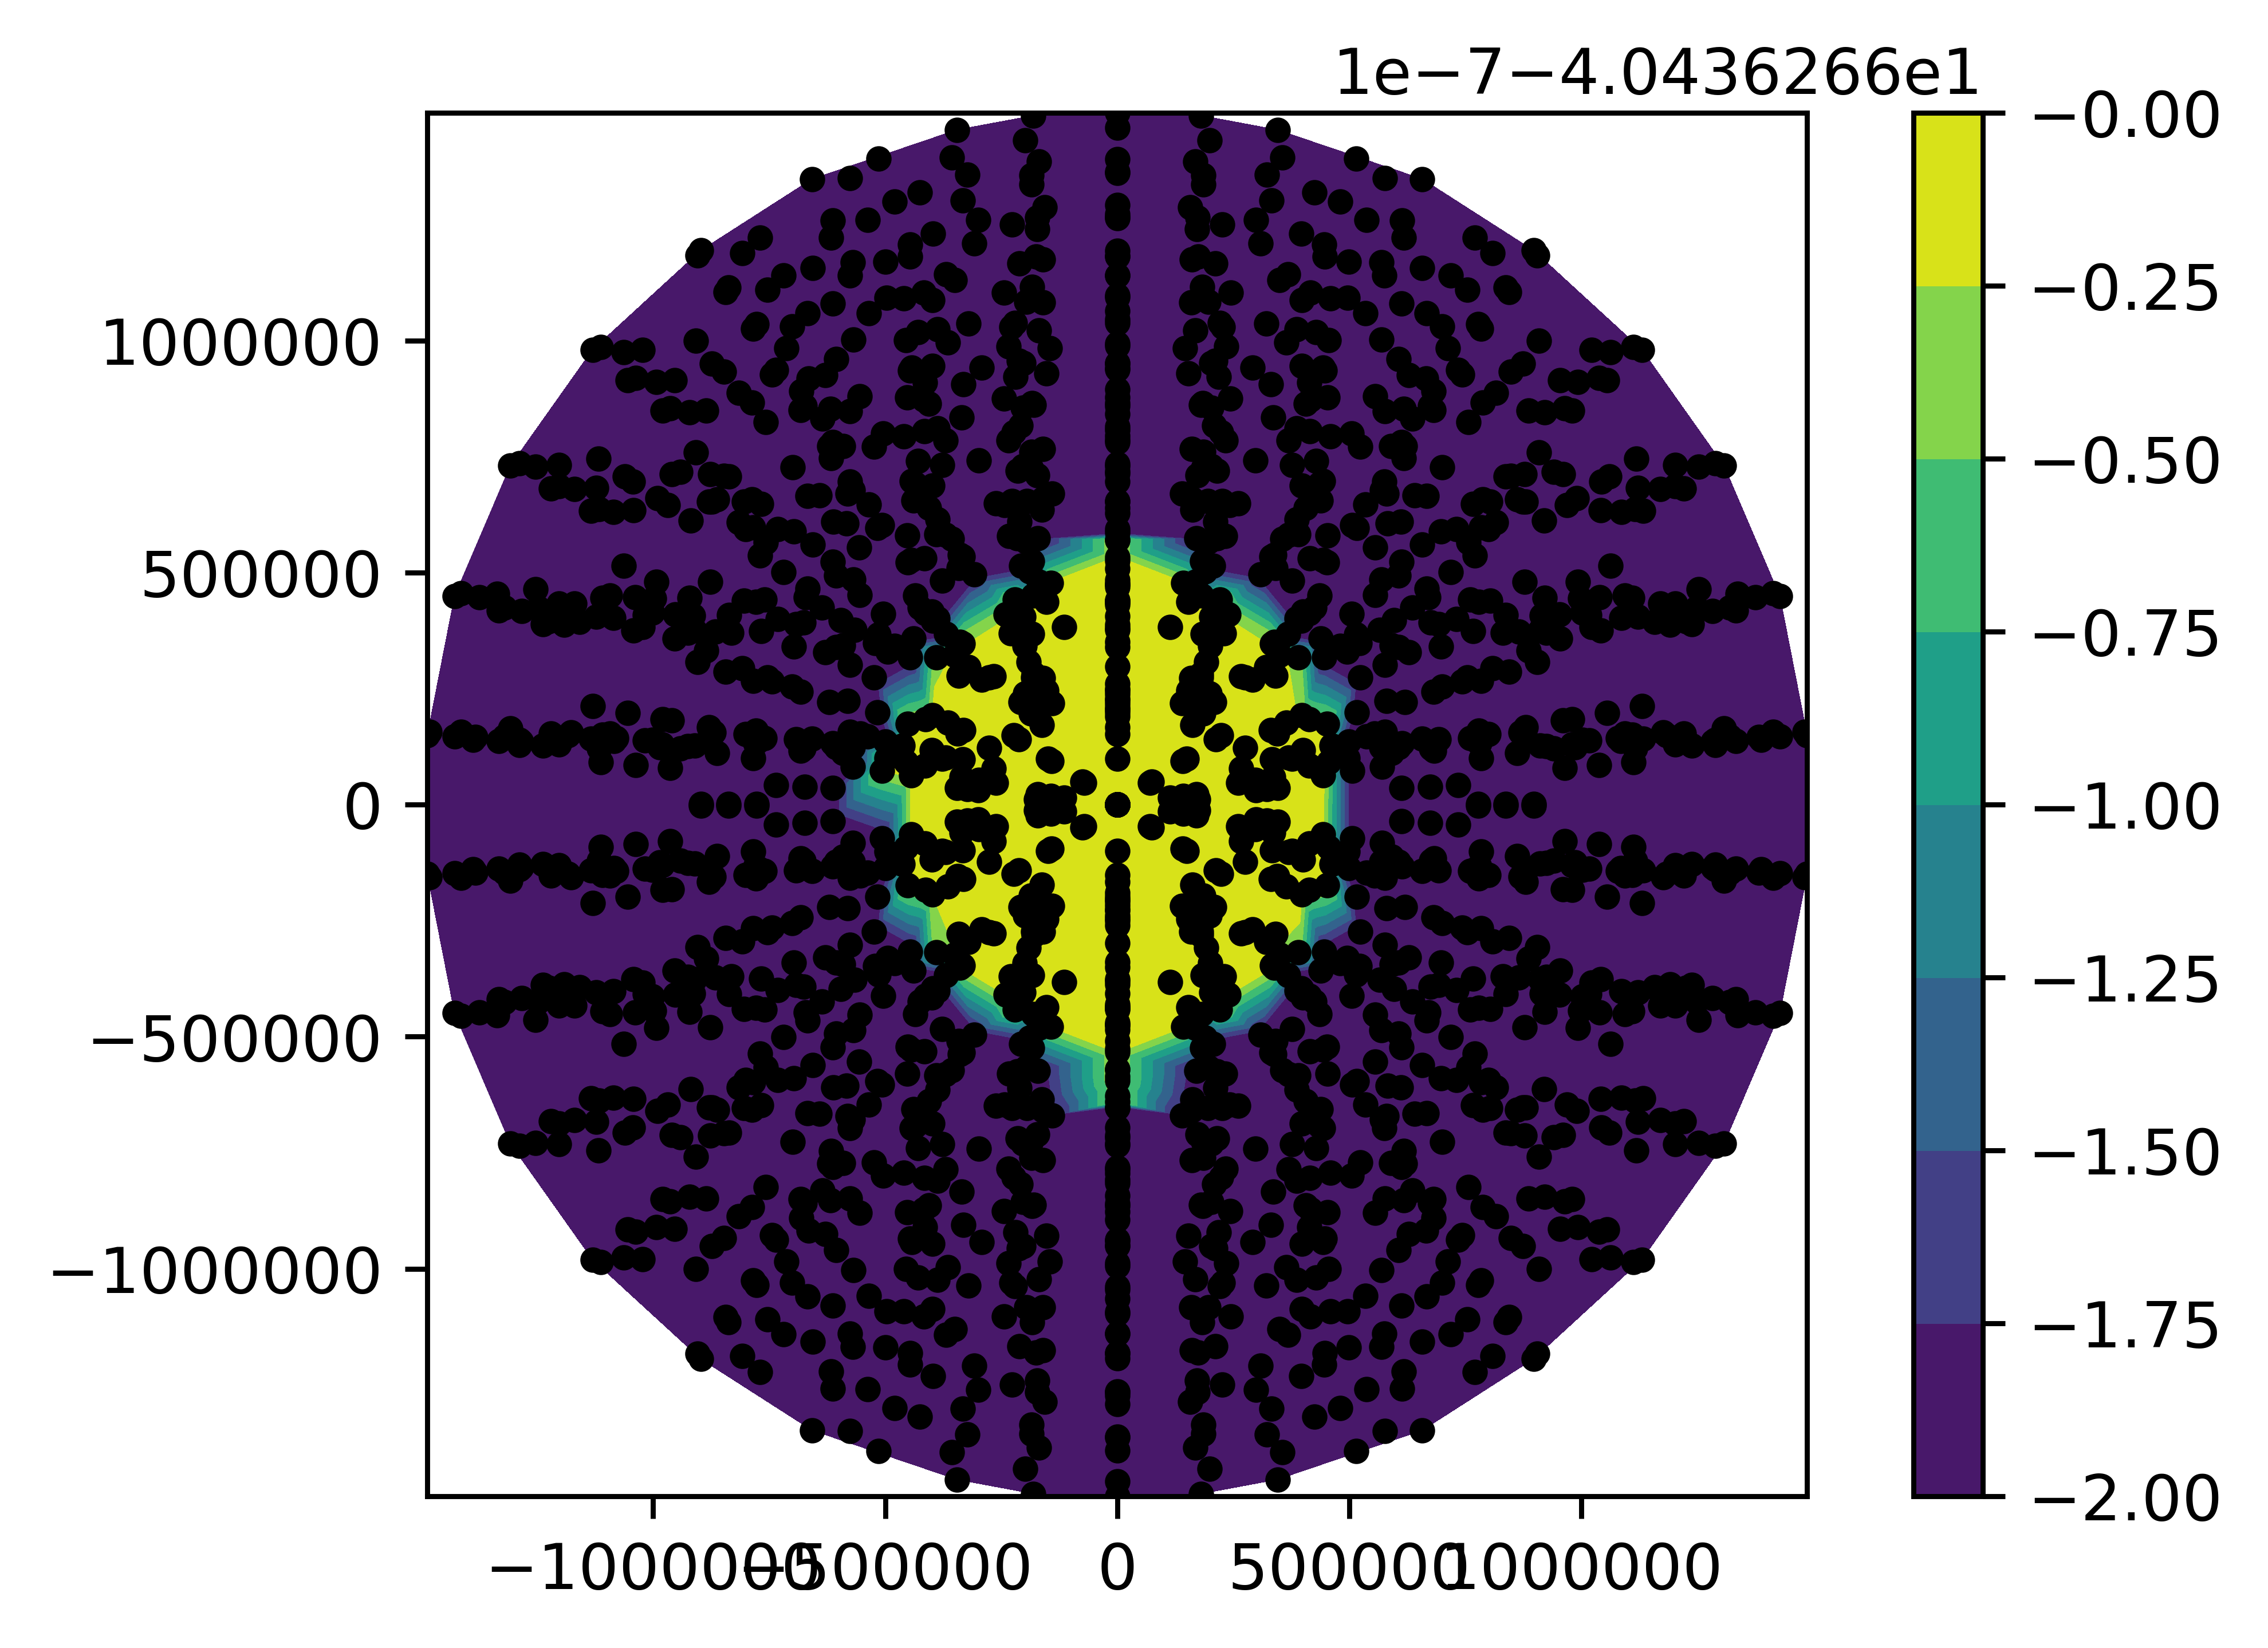

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

data = np.loadtxt(lastOutput + 'image_m_0.txt')

ncells_eff = model3D.ncells - len(model3D.boundary)

f = 19

imdata = data[:ncells_eff,f]

model3D.imageRay(0)
x = model3D.imageX[:ncells_eff]
y = model3D.imageY[:ncells_eff]

plt.figure(dpi=800)
plt.plot(x, y, 'k.')
plt.tricontourf(x,y,np.log(imdata))
plt.colorbar()
plt.axes().set_aspect('equal')

In [8]:
print(imdata)

[ 2.39198891e-16  2.39198893e-16  2.39198892e-16 ... -2.33707618e-16
 -2.33690956e-16 -2.33707618e-16]


### Map sphere to 1D model

In [11]:
pops_data = deSphere(cellsInShell, pops_3D_data)
pops_var  = sphereVar(cellsInShell, pops_3D_data)

J_data = deSphere(cellsInShell, J_3D_data)
J_var   = sphereVar(cellsInShell, J_3D_data)

Jeff_data = deSphere(cellsInShell, Jeff_3D_data)
Jeff_var  = sphereVar(cellsInShell, Jeff_3D_data)

nu_data = deSphere(cellsInShell, nu_3D_data)
nu_var  = sphereVar(cellsInShell, nu_3D_data)

lnr_data = deSphere(cellsInShell, lnr_3D_data)
lnr_var  = sphereVar(cellsInShell, lnr_3D_data)

#freqsR   = deSphere(cellsInShell, [freqs])
#freqsVar = sphereVar(cellsInShell, [freqs])

#etaR   = deSphere(cellsInShell, eta_data)
#etaVar = sphereVar(cellsInShell, eta_data)

#chiR   = deSphere(cellsInShell, chi_data)
#chiVar = sphereVar(cellsInShell, chi_data)

for s in range(model.ncells):
    print(f'pops_var  = {np.max(pops_var[0][s])}')
    print(f'Jeff_var  = {np.max(Jeff_var[0][s])}')
    print(f'J_var     = {np.max(J_var[0][s])}')
    print(f'nu_var    = {np.max(nu_var[0][s])}')
    print(f'lnr_var   = {np.max(lnr_var[0][s])}')

#print(np.max(etaVar))
#print(np.max(chiVar))

pops_var  = 0.0
Jeff_var  = 0.0
J_var     = 0.0
nu_var    = 0.0
lnr_var   = 0.0
pops_var  = 1.8251018876176273e-16
Jeff_var  = 0.0
J_var     = 0.00021171856331878814
nu_var    = 2.0561025600431512e-16
lnr_var   = 0.0
pops_var  = 1.8251018876176273e-16
Jeff_var  = 0.0
J_var     = 0.09473735660034842
nu_var    = 2.0561025600431512e-16
lnr_var   = 0.0
pops_var  = 1.8251018876176273e-16
Jeff_var  = 0.0
J_var     = 0.051636851881678776
nu_var    = 2.0561025600431512e-16
lnr_var   = 0.0
pops_var  = 6.182604716840357e-16
Jeff_var  = 0.0
J_var     = 0.05242551866139966
nu_var    = 6.848491123081089e-16
lnr_var   = 0.0
pops_var  = 6.182604716840357e-16
Jeff_var  = 0.0
J_var     = 0.05238854074032903
nu_var    = 6.848491123081089e-16
lnr_var   = 0.0
pops_var  = 6.182604716840357e-16
Jeff_var  = 0.0
J_var     = 0.10323004510427268
nu_var    = 6.848491123081089e-16
lnr_var   = 0.0
pops_var  = 1.1900920907776962e-15
Jeff_var  = 0.0
J_var     = 0.16562258892044776
nu_var    = 1.4542824894339495e-15


### Plot output

In [12]:
s_min  = 0
s_max  = model.ncells
s_step = 1
ns     = int((s_max - s_min) / s_step)

In [13]:
plot_pops = figure (title='Level populations', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    plot_pops.line(range(lineData.nlev), pops_data[0][s], color=cividis(ns)[int(s/s_step)], legend=str(s))
plot_pops.xaxis.axis_label = "number of the level"
plot_pops.yaxis.axis_label = "population [m^-3]"
show (plot_pops)

In [14]:
plot_Jeff = figure (title='Total mean intensity', width=700, height=400, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    plot_Jeff.line(range(lineData.nrad), Jeff_data[1][s], color=cividis(ns)[int(s/s_step)], legend=str(s))
plot_Jeff.xaxis.axis_label = "number of the transition"
plot_Jeff.yaxis.axis_label = "mean intensity J [m^-3]"
show (plot_Jeff)

In [15]:
plot_spectrum = figure (title='Spectrum', width=700, height=500, y_axis_type='log')
for s in range(s_min, s_max, s_step):
    plot_spectrum.line(nu_data[0][s], J_data[0][s], color=cividis(ns)[int(s/s_step)], legend=str(s))
plot_spectrum.xaxis.axis_label = "frequencies [Hz]"
plot_spectrum.yaxis.axis_label = "Mean intensity [W/m^2]"
show(plot_spectrum)

## Analytical solution

Assuming a constant source function $S_{\nu}(x)=S_{\nu}$ along the ray and boundary condition $B_{\nu}$ on both sides of the ray, the mean intensity is given by

\begin{align}
    J_{\nu}^{\text{ray}}(\tau(x)) \ = \ S_{\nu} \ + \ \frac{1}{2} \ \left(B_{\nu}-S_{\nu}\right) \ \left[e^{-\tau_{\nu}(x)} + e^{-\tau_{\nu}(L-x)}\right],
\end{align}

where the optical depth $\tau_{\nu}$ is given by

\begin{equation}
    \tau_{\nu}(\ell) \ = \ \int_{0}^{\ell} \text{d} l \ \chi_{\nu}(l) .
\end{equation}

The frequency dependence of the opacity only comes from the line profile

\begin{equation}
    \chi_{\nu}(x) \ = \ \chi_{ij} \phi_{\nu},
\end{equation}

where we assume a Gaussian profile

\begin{equation}
	\phi_{\nu}^{ij}(x) \ = \ \frac{1}{\sqrt{\pi} \ \color{red}\delta\color{red}\nu_{\color{red}i\color{red}j}} \ \exp \left[-\left(\frac{\nu-\nu_{ij}} {\delta\nu_{ij}(x)}\right)^{2}\right], \hspace{5mm} \text{where} \hspace{5mm} \delta\nu_{ij}(x) \ = \ \frac{\nu_{ij}}{c} \sqrt{ \frac{2 k_{b} T(x)}{m_{\text{spec}}} \ + \ v_{\text{turb}}^{2}(x)}.
\end{equation}

In a sphere of radius $R$, on a dinstence $r$ from the center, the distance $z$ to the boundary in a direction under an angle $\theta$ with the position vector $\textbf{r}$ is

\begin{equation}
z(r,\theta) \ = \ \sqrt{R^{2} + r^{2} \left(1 + \sin^{2} \theta\right)} - r \sin \theta .
\end{equation}
so the optical depth along such a ray is

\begin{equation}
    \tau_{\nu}(r,\theta) \ = \ \chi_{\nu}(l) z(r,\theta)
\end{equation}

and hence the mean intensity is

\begin{align}
    J_{\nu}(r) \ = \ S_{\nu} \ + \ \left(B_{\nu}-S_{\nu}\right) \ \int_{0}^{\pi} \frac{\text{d} \theta}{\pi} \ e^{-\tau_{\nu}(r,\theta)},
\end{align}

To account for the velocity gradient, after a slab of length $\ell$, the frequency shifts as

\begin{equation}
    \nu \ \rightarrow \ \left( 1 - \frac{v_{\max} \ell}{c L} \right) \nu.
\end{equation}

Solving the integral for the optical depth then yields

\begin{equation}
  \tau_{\nu}(\ell) \ = \ \chi L \ \frac{\color{red}\delta\color{red}\nu_{\color{red}i\color{red}j}}{\nu} \ \frac{c}{v_{\max}}  \ \frac{1}{2} \left\{ \text{Erf}\left[\frac{\nu-\nu_{ij}}{\delta\nu_{ij}}\right] \ + \ \text{Erf}\left[\frac{v_{\max}}{c} \frac{\nu}{\delta\nu_{ij}}\frac{\ell}{L} - \frac{\nu-\nu_{ij}}{\delta\nu_{ij}}\right] \right\} .
\end{equation}

In [16]:
from scipy.special import erf

c     = 2.99792458E+8    # [m/s] speed of light
kb    = 1.38064852E-23   # [J/K] Boltzmann's constant
mp    = 1.6726219E-27    # [kg]  proton mass
T_CMB = 2.7254800        # [K]   CMB temperature
vturb = 0.12012E3        # [m/s] turbulent speed

pops       = lineData.LTEpop(temp) * abun
emissivity = lineData.lineEmissivity(pops)
opacity    = lineData.lineOpacity(pops)
source     = emissivity / opacity
bcd        = planck(T_CMB, np.array(lineData.frequency))

line = 10

S    =  source[line]
B    =     bcd[line]
chi  = opacity[line]
L    = model.x[-1]
vmax = model.vx[-1]
nuij = lineData.frequency[line]
dnu  = nuij/c * np.sqrt(2.0*kb*temp/mp + vturb**2)

def tau(nu, l):
    arg = (nu - nuij) / dnu
    fct = vmax/c * nu/dnu
    return chi*L / (fct*dnu) * 0.5 * (erf(arg) + erf(fct*l/L-arg))

def JJ(tau1, tau2):
    return S + 0.5 * (B-S) * (np.exp(-tau1) + np.exp(-tau2))

def J(nu, x):
    tau1 = tau(nu, x)
    tau2 = tau(nu, L-x)
    return JJ(tau1, tau2)

def relativeError(a,b):
    return 2.0 * np.abs((a-b)/(a+b))

In [17]:
s_min = 0
s_max = model.ncells-1

plot_line_model = figure(title='Line model: freq dependence', width=450, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    # model
    vv = nuij + 8 * dnu * np.linspace(-1,1,500)
    xx = model.x[s]
    plot_line_model.line(vv, J(vv,xx), color=cividis(ns)[int(s/s_step)])
    # data
    M = int(lnr_data[0][s][line] - 18    )
    N = int(lnr_data[0][s][line] + 18 + 1)
    plot_line_model.circle(nu_data[0][s][M:N], J_data[0][s][M:N], color=cividis(ns)[int(s/s_step)], legend=str(s))

plot_line_error = figure(title='Line error', width=450, height=400, y_axis_type="log")
for s in range(s_min, s_max, s_step):
    M = int(lnr_data[0][s][line] - 18    )
    N = int(lnr_data[0][s][line] + 18 + 1)
    vv = nu_data[0][s][M:N]
    xx = model.x[s]
    error = relativeError(J(vv,xx), J_data[0][s][M:N])
    plot_line_error.circle(vv, error, color=cividis(ns)[int(s/s_step)], legend=str(s))

plot_line = gridplot([[plot_line_model, plot_line_error]])

show (plot_line)

In [25]:
plot_line_model = figure(title='Line model: space dependence', width=450, height=400, y_axis_type="log")
#for s in range(s_min, s_max, 2):
# model
xx = np.array(model.x)
plot_line_model.line(xx, J(nuij,xx))
# data
M = int(lnr_data[0][0][line])
plot_line_model.circle(xx, J_data[0][:,M])
plot_line_model.xaxis.axis_label = "x [m]"
plot_line_model.yaxis.axis_label = "Mean intensity [W/m^2]"

plot_line = gridplot([[plot_line_model, plot_line_error]])

show (plot_line)

In [26]:
plot_line_model = figure(title='Line model', width=450, height=400, y_axis_type="log")
#for s in range(s_min, s_max, 2):
# model
xx = np.array(model.x)
plot_line_model.line(xx, J(nuij,xx))
# data
M = int(lnr_data[0][0][line])
plot_line_model.circle(xx, Jeff_data[0][:,line])

plot_line = gridplot([[plot_line_model, plot_line_error]])

show (plot_line)